# Bab 3: Klasifikasi

Setelah mempelajari alur kerja proyek ML di Bab 2, bab ini menyelam lebih dalam ke salah satu tugas *supervised learning* yang paling umum: **klasifikasi**. Kita akan menggunakan dataset MNIST, yang sering disebut sebagai "hello world"-nya Machine Learning, sebagai contoh utama. Bab ini mencakup cara melatih *classifier*, mengukur kinerjanya dengan berbagai metrik, dan menangani berbagai jenis tugas klasifikasi.

## Dataset MNIST

MNIST adalah dataset berisi 70.000 gambar kecil angka tulisan tangan (0-9) yang dikumpulkan dari siswa SMA dan pegawai Biro Sensus AS. Setiap gambar berukuran 28x28 piksel dan memiliki label angka yang diwakilinya.

In [1]:
from sklearn.datasets import fetch_openml

# Memuat dataset MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

Dataset ini sudah dibagi menjadi *training set* (60.000 gambar pertama) dan *test set* (10.000 gambar terakhir). Sangat penting untuk selalu memisahkan *test set* dan tidak menyentuhnya sampai kita siap mengevaluasi model final.

In [2]:
import numpy as np

# Mengubah label dari string ke integer
y = y.astype(np.uint8)

# Memisahkan training dan test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Melatih Binary Classifier

Sebagai langkah awal, kita akan menyederhanakan masalah: mencoba mengidentifikasi satu digit saja, misalnya angka 5. Ini adalah contoh *binary classifier*, yang mampu membedakan antara dua kelas: "angka 5" dan "bukan angka 5".

In [3]:
# Membuat target untuk binary classification
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Memilih dan melatih model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## Metrik Kinerja

Mengevaluasi sebuah *classifier* seringkali lebih rumit daripada mengevaluasi *regressor*. Ada beberapa metrik yang perlu kita pahami.

### Akurasi Menggunakan Cross-Validation
Akurasi adalah rasio prediksi yang benar. Meskipun terdengar intuitif, akurasi bisa menyesatkan, terutama pada dataset yang tidak seimbang (*skewed dataset*).

### Confusion Matrix
Cara yang jauh lebih baik untuk mengevaluasi kinerja *classifier* adalah dengan melihat *confusion matrix*. Matriks ini menunjukkan berapa kali instance dari kelas A diklasifikasikan sebagai kelas B. Dari sini, kita bisa menghitung metrik yang lebih informatif.

Istilah dalam Confusion Matrix:
- **True Negatives (TN):** Instance negatif yang diklasifikasikan dengan benar.
- **False Positives (FP):** Instance negatif yang salah diklasifikasikan sebagai positif.
- **False Negatives (FN):** Instance positif yang salah diklasifikasikan sebagai negatif.
- **True Positives (TP):** Instance positif yang diklasifikasikan dengan benar.

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

print(confusion_matrix(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]


### Precision dan Recall

- **Precision (Presisi):** Akurasi dari prediksi positif. 
  $$ Precision = \frac{TP}{TP + FP} $$ 
  Ini menjawab pertanyaan: "Dari semua instance yang diprediksi positif, berapa persen yang benar-benar positif?"

- **Recall (Sensitivitas atau True Positive Rate):** Rasio instance positif yang berhasil dideteksi oleh *classifier*.
  $$ Recall = \frac{TP}{TP + FN} $$ 
  Ini menjawab pertanyaan: "Dari semua instance yang sebenarnya positif, berapa persen yang berhasil dideteksi?"

Seringkali, ada *trade-off* antara *precision* dan *recall*: meningkatkan yang satu cenderung menurunkan yang lain. Pilihan mana yang lebih penting tergantung pada masalah. Contohnya, untuk mendeteksi video yang aman untuk anak-anak, kita ingin *precision* yang sangat tinggi (lebih baik menolak beberapa video bagus daripada membiarkan satu video buruk lolos).

### Kurva ROC

Kurva **Receiver Operating Characteristic (ROC)** adalah alat umum lain yang digunakan untuk *binary classifier*. Kurva ini memplot **True Positive Rate (Recall)** terhadap **False Positive Rate (FPR)**. FPR adalah rasio instance negatif yang salah diklasifikasikan sebagai positif.

Ukuran kinerja yang baik adalah **Area Under the Curve (AUC)**. *Classifier* yang sempurna akan memiliki ROC AUC sama dengan 1, sedangkan *classifier* yang murni acak akan memiliki ROC AUC sama dengan 0.5.

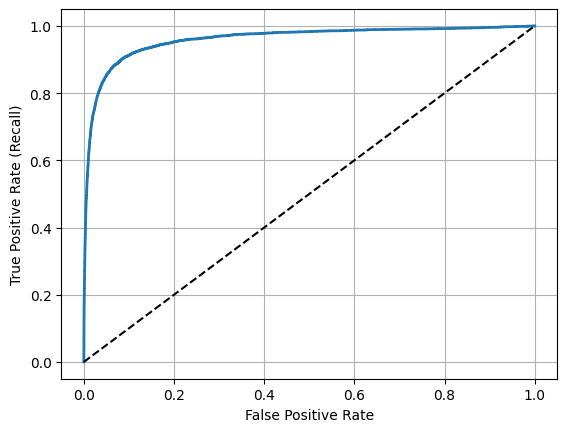

ROC AUC Score: 0.9604938554008616


In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis putus-putus diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)

import matplotlib.pyplot as plt
plot_roc_curve(fpr, tpr)
plt.show()

print("ROC AUC Score:", roc_auc_score(y_train_5, y_scores))

## Klasifikasi Multiclass, Multilabel, dan Multioutput

Bab ini juga membahas cara memperluas tugas klasifikasi:

* **Multiclass Classification:** Membedakan antara lebih dari dua kelas (misalnya, semua 10 digit di MNIST). Beberapa algoritma (seperti Random Forest) dapat menanganinya secara native, sementara yang lain (seperti SVM) adalah *binary classifier* murni. Untuk yang terakhir, Scikit-Learn secara otomatis menggunakan strategi **One-vs-the-Rest (OvR)** atau **One-vs-One (OvO)**.

* **Multilabel Classification:** Sistem klasifikasi yang dapat mengeluarkan beberapa label biner untuk setiap instance. Contoh: *classifier* pengenal wajah yang dapat mendeteksi beberapa orang dalam satu gambar.

* **Multioutput Classification:** Generalisasi dari *multilabel classification* di mana setiap label bisa *multiclass*. Contoh: sistem yang menghilangkan *noise* dari gambar, di mana setiap piksel adalah sebuah label dengan nilai dari 0 hingga 255.